In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import pandas as pd
from StockTradingRLEnv_Abhi_submittable_1 import StockTradingEnv, INITIAL_ACCOUNT_BALANCE
import matplotlib.pyplot as plt


In [2]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 8)
        self.fc4 = nn.Linear(8, output_dim)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        # x = torch.nn.functional.softmax(x, dim=-1)
        return x

In [3]:
class Agent:
    def __init__(self, state_dim, is_eval=False, model_name=""):
        self.state_dim = state_dim
        self.action_dim = 2  # 0: Buy, 1: Sell 2: hold
        self.memory = deque(maxlen=200)
        
        self.batch_size = 32
        self.tau = 0.0001
        self.gamma = 0.95
        self.epsilon = 1.0  # initial exploration rate
        self.epsilon_min = 0.01  # minimum exploration rate
        self.epsilon_decay = 0.999
        self.is_eval = is_eval
        
        self.model = DQN(state_dim, self.action_dim)
        self.target_model = DQN(state_dim, self.action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.loss_fn = nn.MSELoss()
        
        if self.is_eval:
            self.model.load_state_dict(torch.load(f'saved_models/{model_name}'))
            self.target_model.load_state_dict(torch.load(f'saved_models/{model_name}'))
        else:    
            self.update_target_model()
        
    def update_target_model(self):
        for target_param, param in zip(self.target_model.parameters(), self.model.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
    def act(self, state):
        if not self.is_eval and random.random() <= self.epsilon:
            action_type = random.randrange(0,self.action_dim)  # 0 for buy, 1 for sell, 2 for hold
            return action_type
        state = torch.FloatTensor(state).unsqueeze(0)
        q_values = self.model(state)
        # print("q_values",q_values)
        action_type = torch.argmax(q_values[0]).item()
        # print("action_type",action_type, "epsilon",self.epsilon)
        return action_type
        
    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        minibatch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state).unsqueeze(0)
            next_state = torch.FloatTensor(next_state).unsqueeze(0)
            
            # Predict Q-values for current state
            target = self.model(state).detach().clone()
            
            if done:
                target[0][action] = reward
            else:
                # Select the action using the main model
                next_action = torch.argmax(self.model(next_state)[0]).item()
                
                # Evaluate the action using the target model
                t = self.target_model(next_state)[0]
                target[0][action] = reward + self.gamma * t[next_action].item()
            
            # Get the current Q-values
            output = self.model(state)
            
            # Calculate loss and perform backpropagation
            loss = self.loss_fn(output, target)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        
        # Update epsilon for the epsilon-greedy strategy
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


    def load(self, name):
        self.model.load_state_dict(torch.load(name))
        
    def save(self, name):
        torch.save(self.model.state_dict(), f'saved_models/{name}.pth')

In [4]:
def plot_buy_sell(env, trades):
    plt.figure(figsize=(12,3.5))

    # Plot stock price with a thinner line
    plt.plot(env.df['Date'], env.df['Close'], label='Stock Price', linewidth=1, color='b')

    # Extract buy and sell trades
    buy_trades = [trade for trade in trades if trade[1] == 0]
    sell_trades = [trade for trade in trades if trade[1] == 1]

    plt.scatter(env.df.loc[[trade[0] for trade in sell_trades], 'Date'], 
                env.df.loc[[trade[0] for trade in sell_trades], 'Close'], 
                marker='v', color='r', s=40, label='Sell', alpha=1)
    
    plt.scatter(env.df.loc[[trade[0] for trade in buy_trades], 'Date'], 
                env.df.loc[[trade[0] for trade in buy_trades], 'Close'], 
                marker='^', color='g', s=40, label='Buy', alpha=0.6)


    # Labels and title
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Stock Trades')

    # Show legend
    plt.legend()

    # Show plot
    plt.show()
    

In [5]:
def plot_networth(env, networths):
    """
    Plot the net worth of the trading bot over time and compare it with the net worth
    if the initial amount was fully invested in the stock.
    """
    dates = env.df['Date']
    stock_prices = env.df['Close']
    
    # Calculate the hypothetical net worth if the initial balance was fully invested in the stock
    initial_stock_price = stock_prices.iloc[0]
    shares_if_fully_invested = INITIAL_ACCOUNT_BALANCE / initial_stock_price
    hypothetical_networths = shares_if_fully_invested * stock_prices
    
    plt.figure(figsize=(12,3.5))
    plt.plot(dates, hypothetical_networths, label='Hypothetical Net Worth (Fully Invested in Stock)', linewidth=1, color='r')
    plt.plot(dates[:len(networths)], networths, label='Actual Net Worth', linewidth=1, color='b')
    
    plt.xlabel('Date')
    plt.ylabel('Net Worth')
    plt.title('DDQN Trading Bot Net Worth Over Time')
    plt.legend()
    plt.show()

In [6]:
# df = pd.read_csv('./data/AAPL.csv')
# df = pd.read_csv('./data/^GSPC_2010-2015.csv')
df = pd.read_csv('./data/^GSPC_2014.csv')
# df = pd.read_csv('./data/^GSPC_2018.csv')
# df = pd.read_csv('./data/FB_2018.csv')
df = df.sort_values('Date')
df.dropna(inplace=True)
df = df.reset_index(drop=True)

env = StockTradingEnv(df, render_mode='human')
state_dim = env.observation_space.shape[1] * env.observation_space.shape[0]
agent = Agent(state_dim=state_dim)

episodes = 20

Time: 100 episode: 1/20 score: 20393.172631984267
Time: 200 episode: 1/20 score: 20052.26455449783
Episode 1/20 - NetWorth: 21812.543545125627


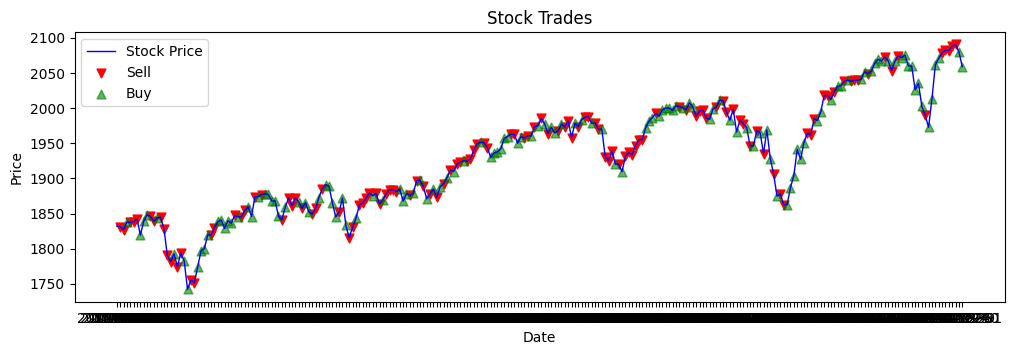

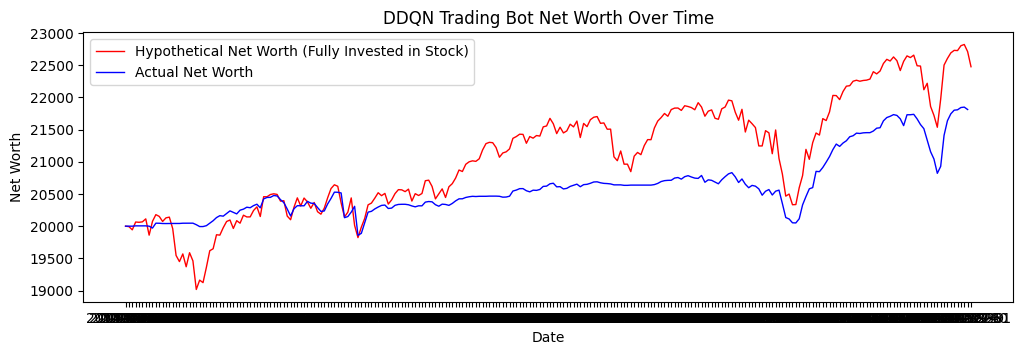

Time: 100 episode: 2/20 score: 20180.282325776054
Time: 200 episode: 2/20 score: 19834.717829219604
Episode 2/20 - NetWorth: 21290.735828806934


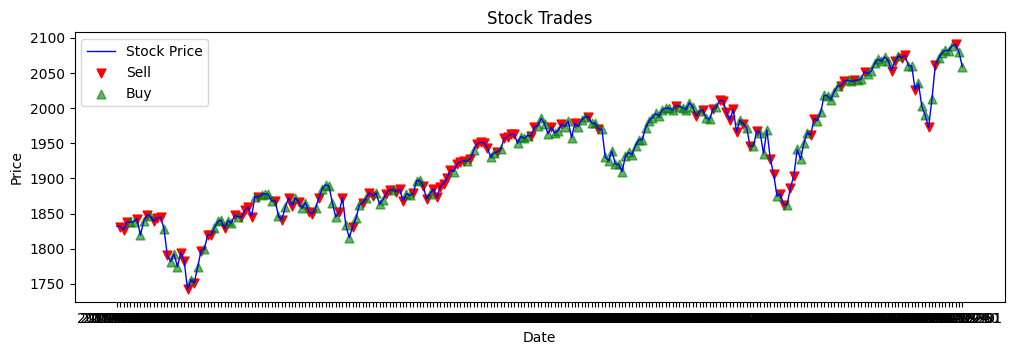

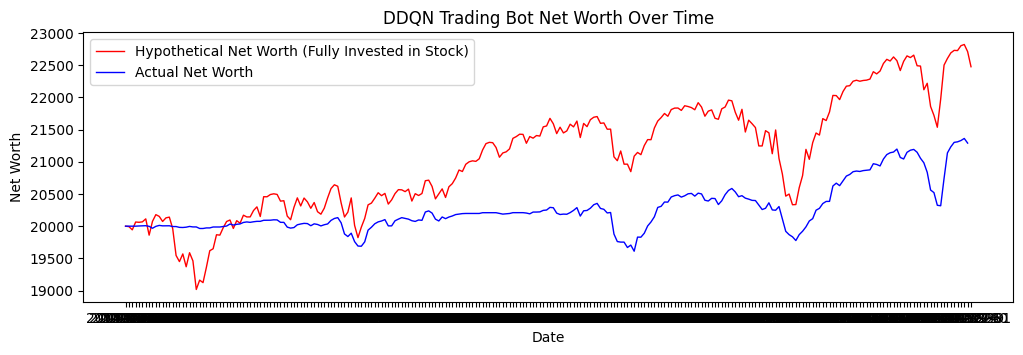

Time: 100 episode: 3/20 score: 20812.62610567566
Time: 200 episode: 3/20 score: 20634.98145796013
Episode 3/20 - NetWorth: 22473.652156503857


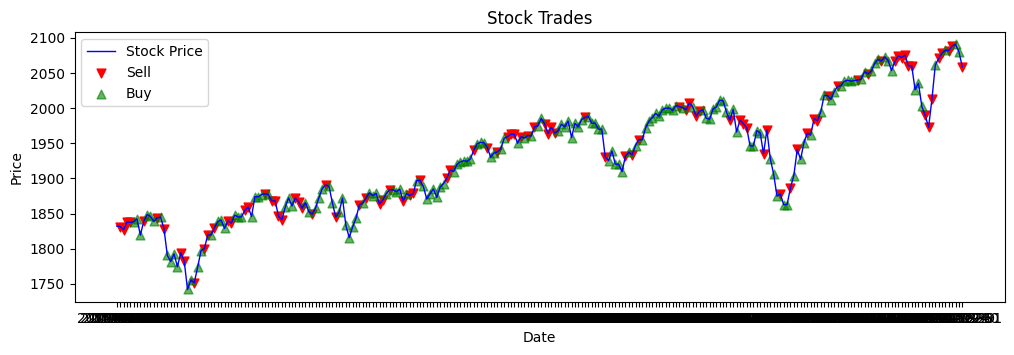

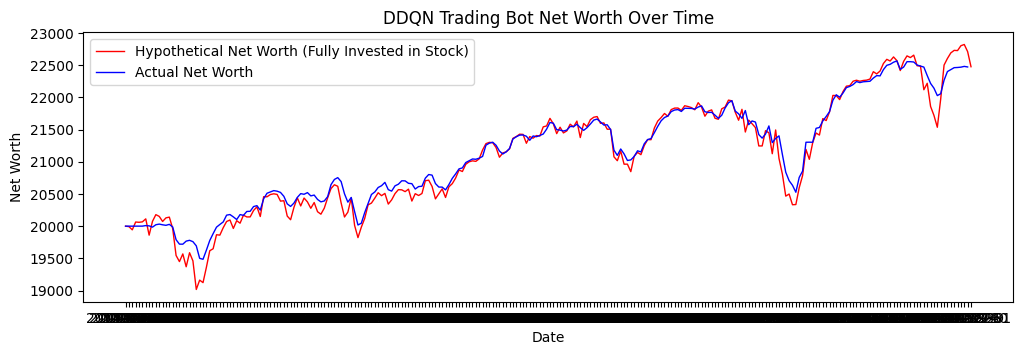

Time: 100 episode: 4/20 score: 20288.266977806903
Time: 200 episode: 4/20 score: 19547.01139610786
Episode 4/20 - NetWorth: 21644.428959901255


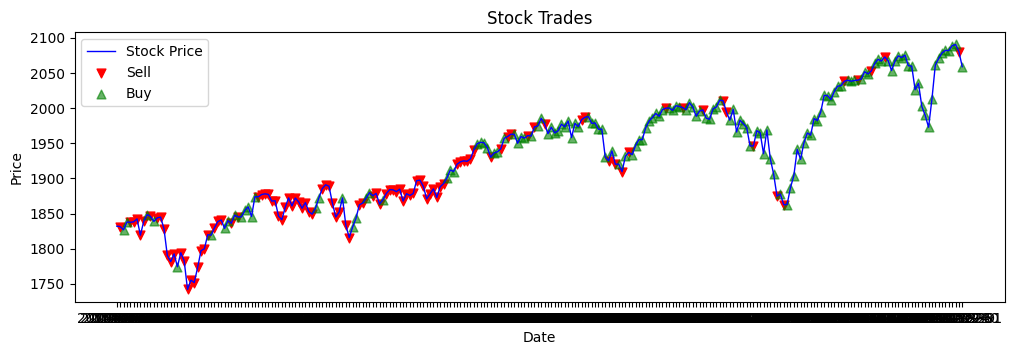

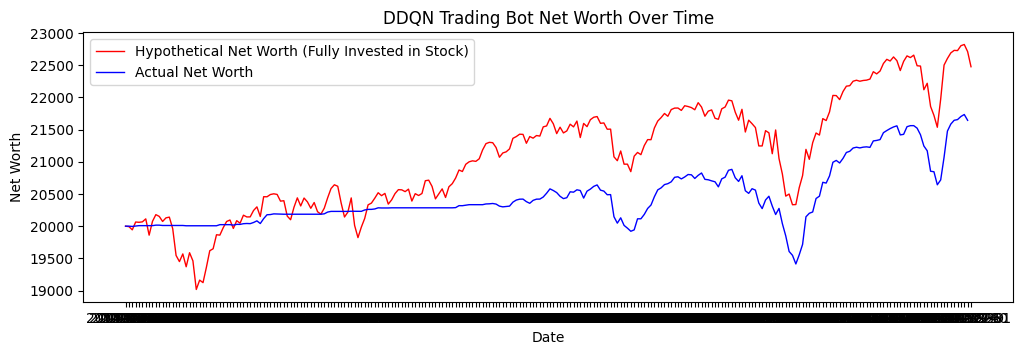

Time: 100 episode: 5/20 score: 20644.08820384933
Time: 200 episode: 5/20 score: 20379.663428844055
Episode 5/20 - NetWorth: 22452.954549144222


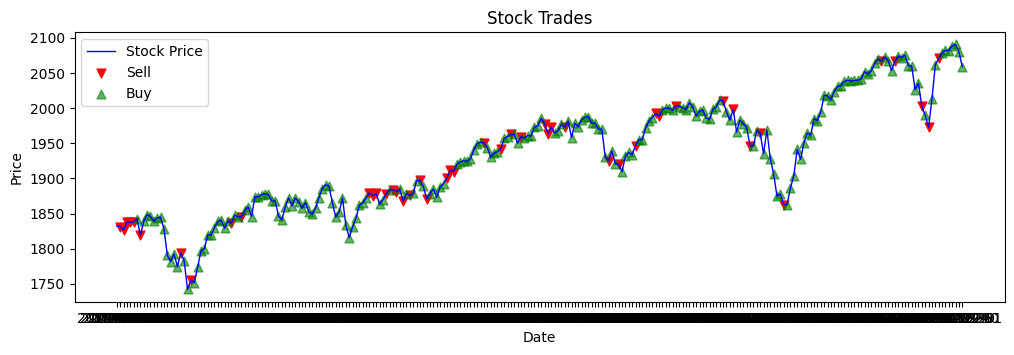

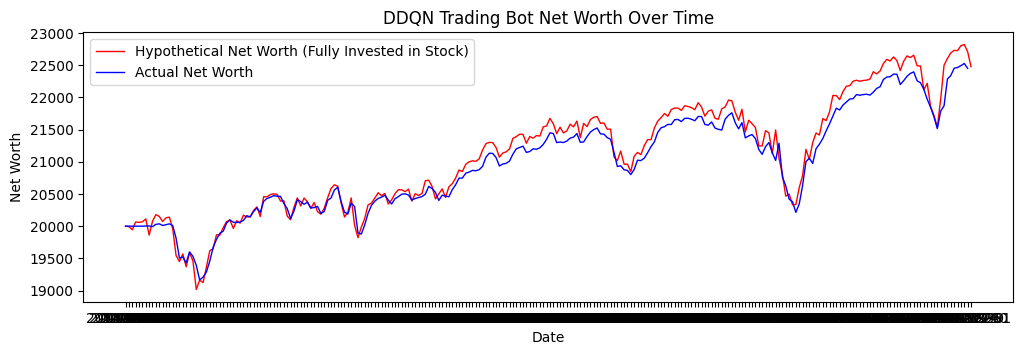

Time: 100 episode: 6/20 score: 20631.570212331208
Time: 200 episode: 6/20 score: 20296.868459567268
Episode 6/20 - NetWorth: 22478.29684165376


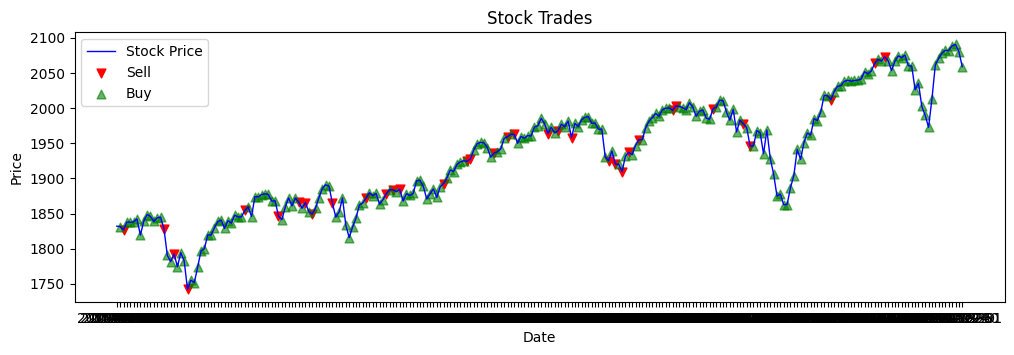

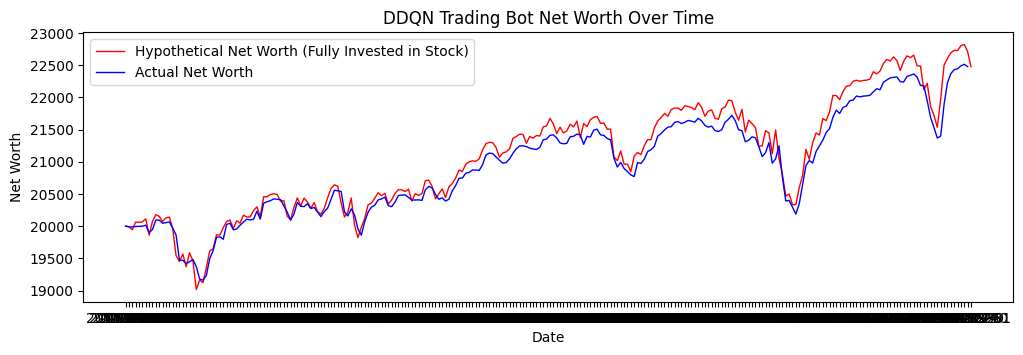

Time: 100 episode: 7/20 score: 20545.591317450904
Time: 200 episode: 7/20 score: 20367.389355865274
Episode 7/20 - NetWorth: 21027.948007230585


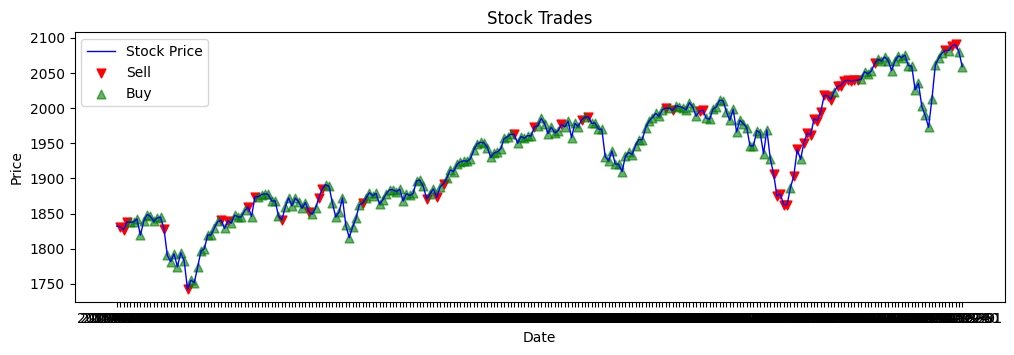

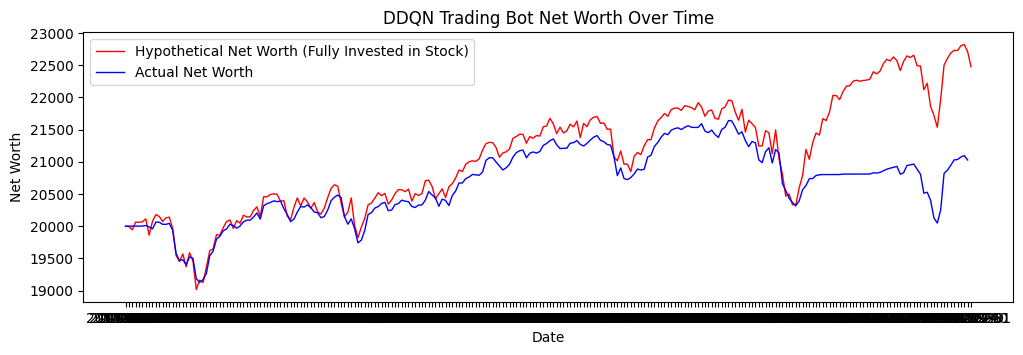

Time: 100 episode: 8/20 score: 20687.682614530975
Time: 200 episode: 8/20 score: 20383.404494021437
Episode 8/20 - NetWorth: 22538.921934097263


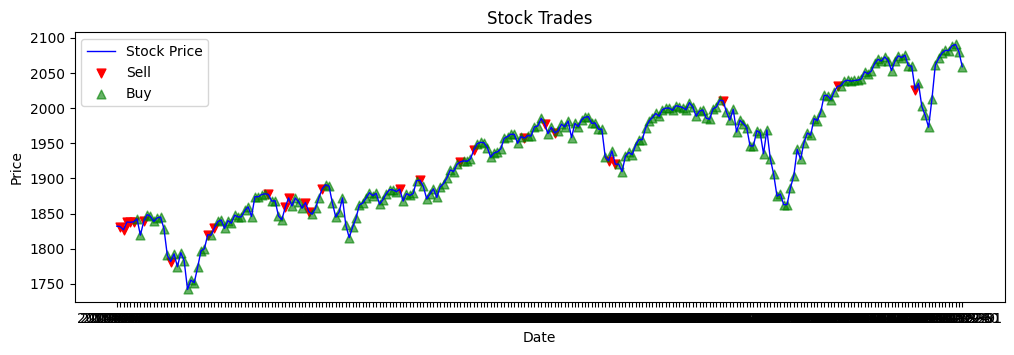

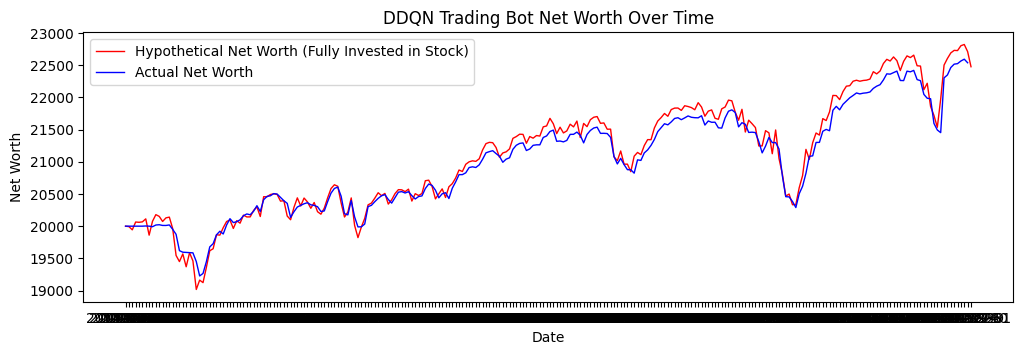

Time: 100 episode: 9/20 score: 20603.531901916267
Time: 200 episode: 9/20 score: 20318.619633536793
Episode 9/20 - NetWorth: 22443.960805132712


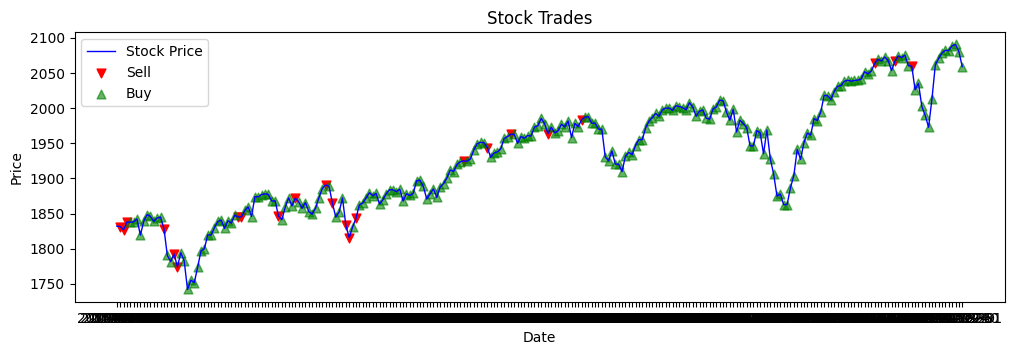

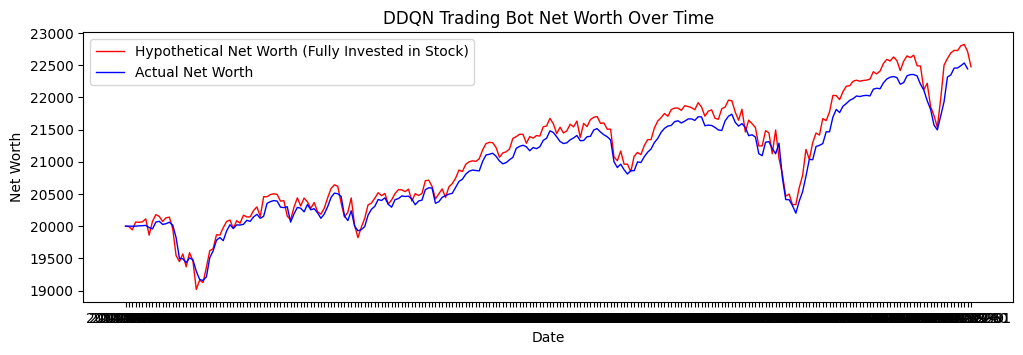

Time: 100 episode: 10/20 score: 20904.384753271806
Time: 200 episode: 10/20 score: 20570.58456829296
Episode 10/20 - NetWorth: 22992.980782875948


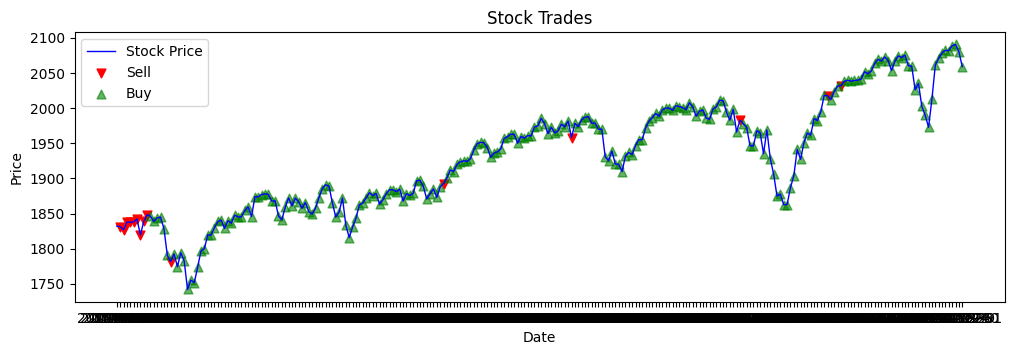

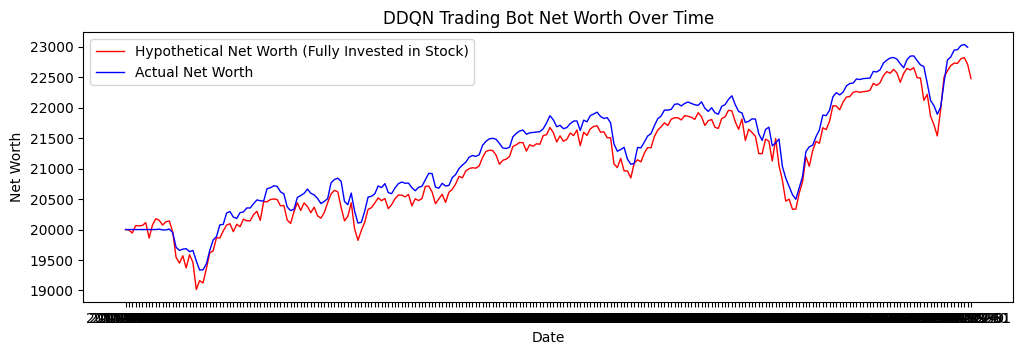

Time: 100 episode: 11/20 score: 20682.213439476196
Time: 200 episode: 11/20 score: 20360.48539641988
Episode 11/20 - NetWorth: 22565.95346872315


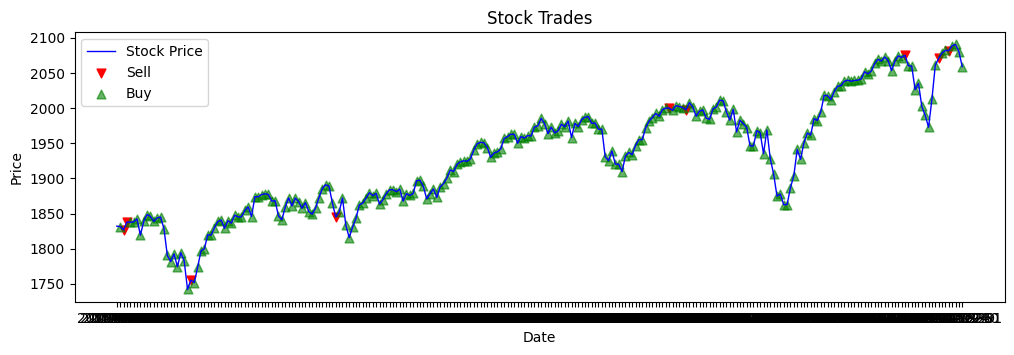

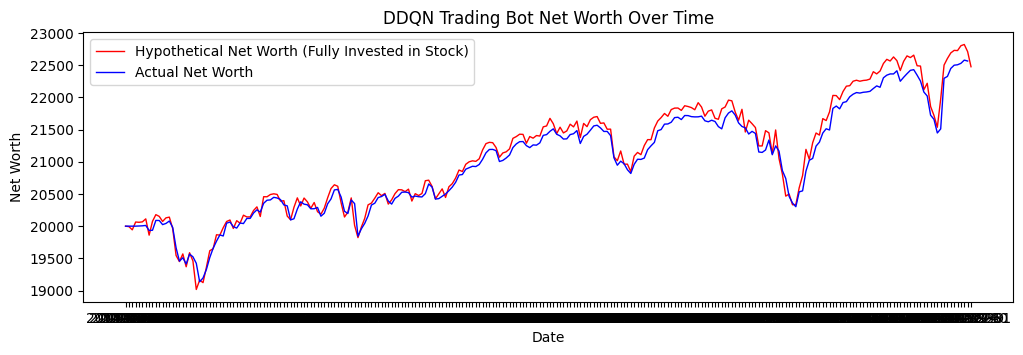

Time: 100 episode: 12/20 score: 20612.649681380815
Time: 200 episode: 12/20 score: 21554.705986873912
Episode 12/20 - NetWorth: 21564.173534519356


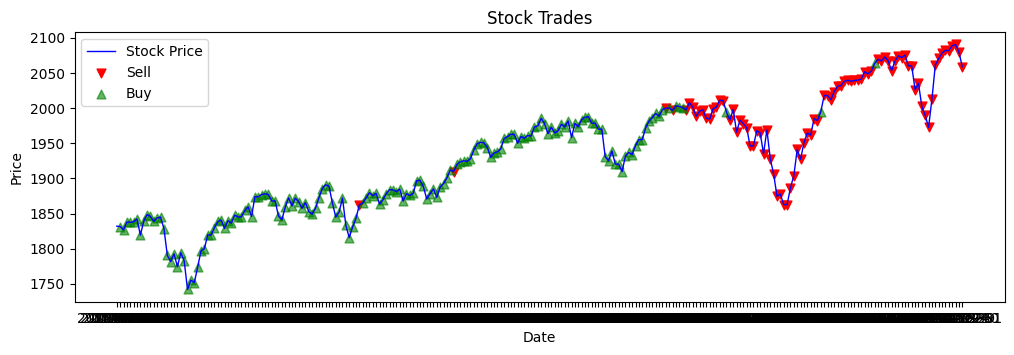

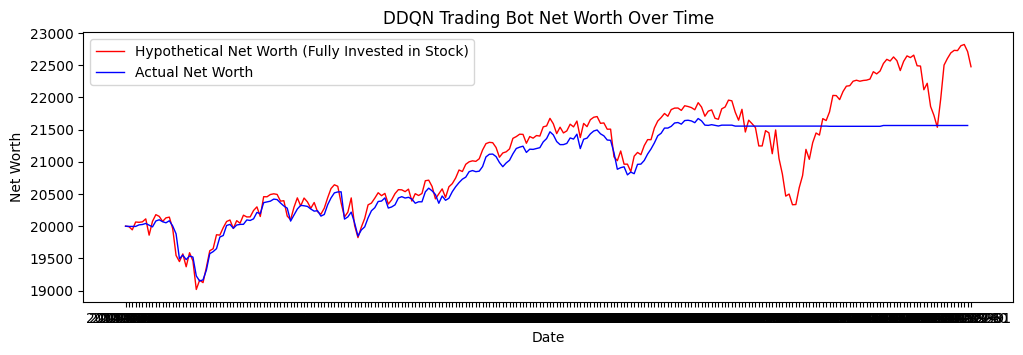

Time: 100 episode: 13/20 score: 20000.0
Time: 200 episode: 13/20 score: 20002.620627302436
Episode 13/20 - NetWorth: 20002.620627302436


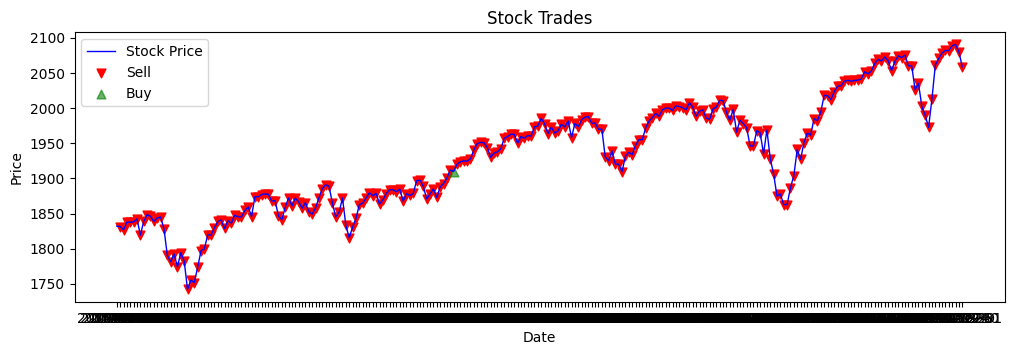

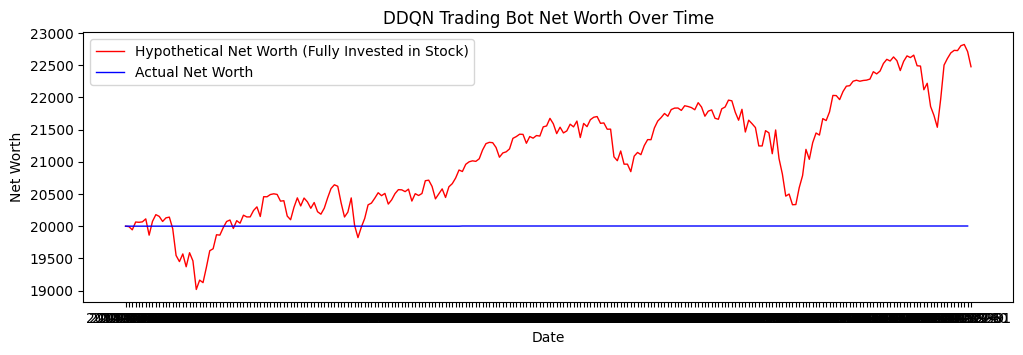

Time: 100 episode: 14/20 score: 20268.31918255077
Time: 200 episode: 14/20 score: 19963.632267469413
Episode 14/20 - NetWorth: 22111.68051249512


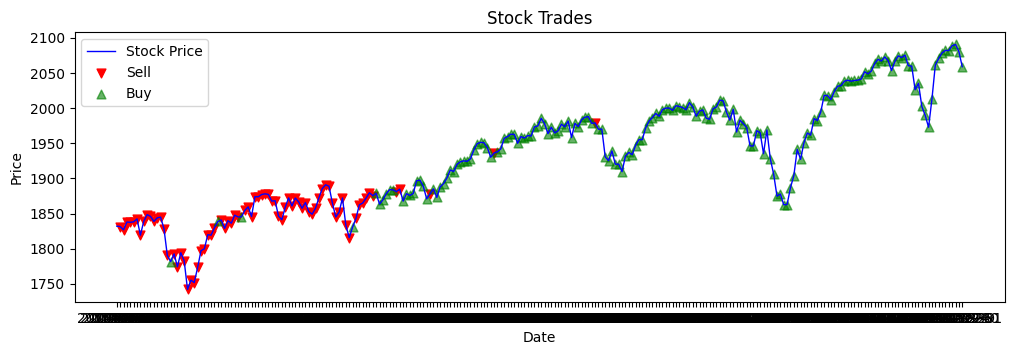

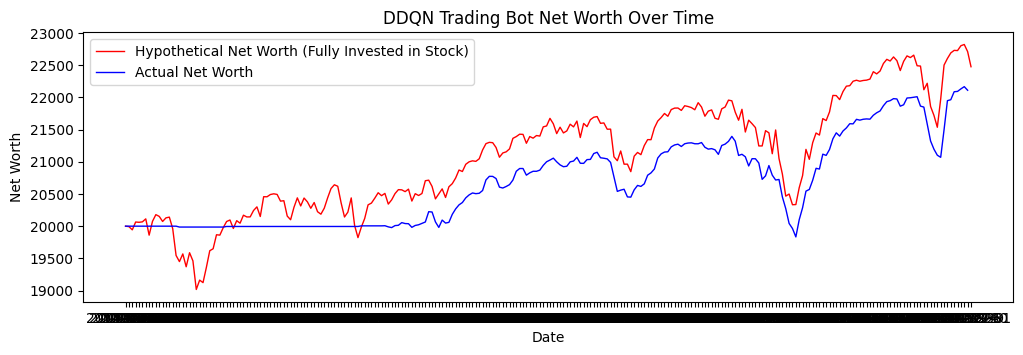

Time: 100 episode: 15/20 score: 20546.29370325616
Time: 200 episode: 15/20 score: 20314.3175973497
Episode 15/20 - NetWorth: 22429.583592425566


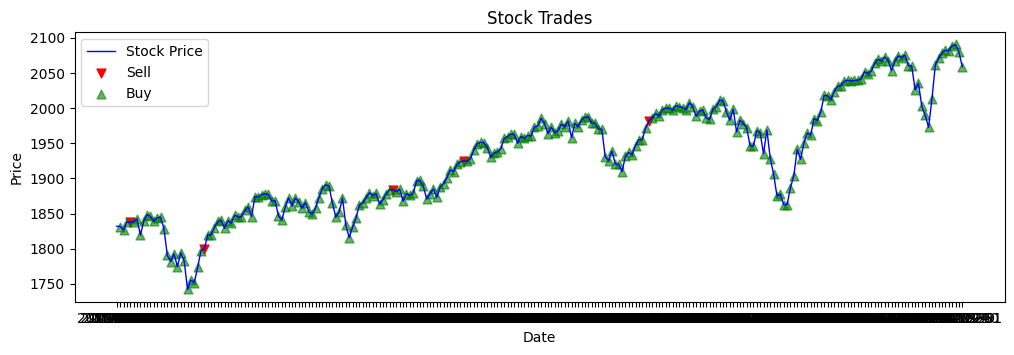

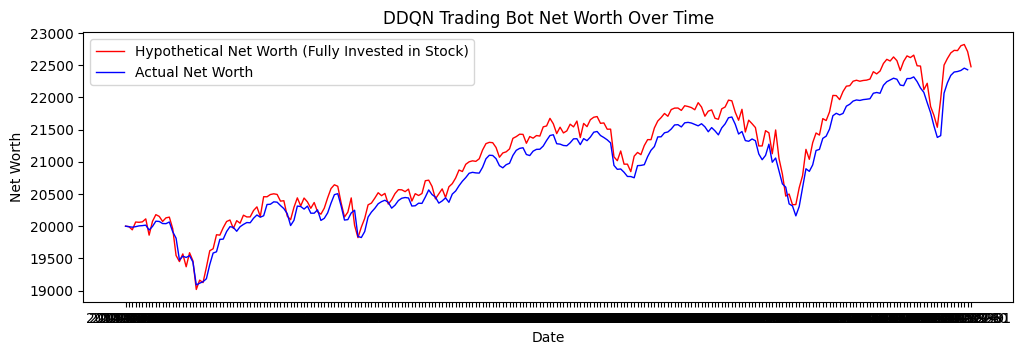

Time: 100 episode: 16/20 score: 20607.897343276694
Time: 200 episode: 16/20 score: 20298.628495903973
Episode 16/20 - NetWorth: 22475.05441184749


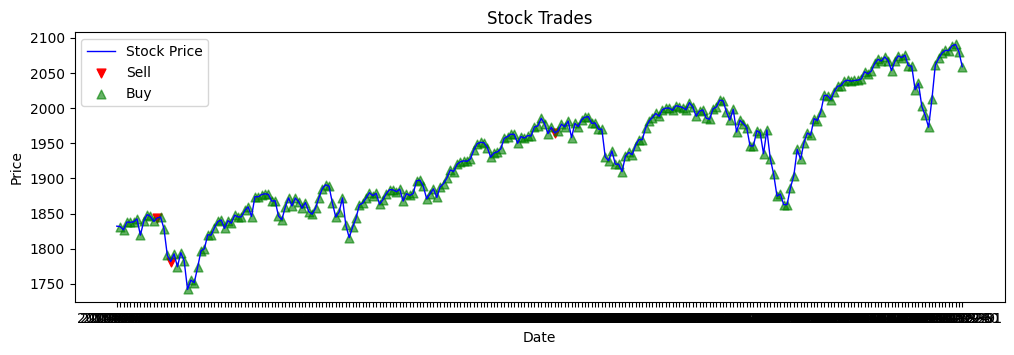

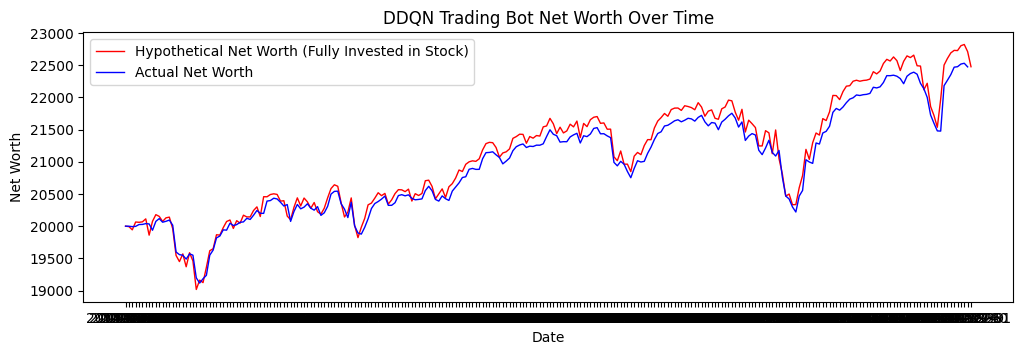

Time: 100 episode: 17/20 score: 20597.61434409444
Time: 200 episode: 17/20 score: 20891.5609046943
Episode 17/20 - NetWorth: 21799.43252247652


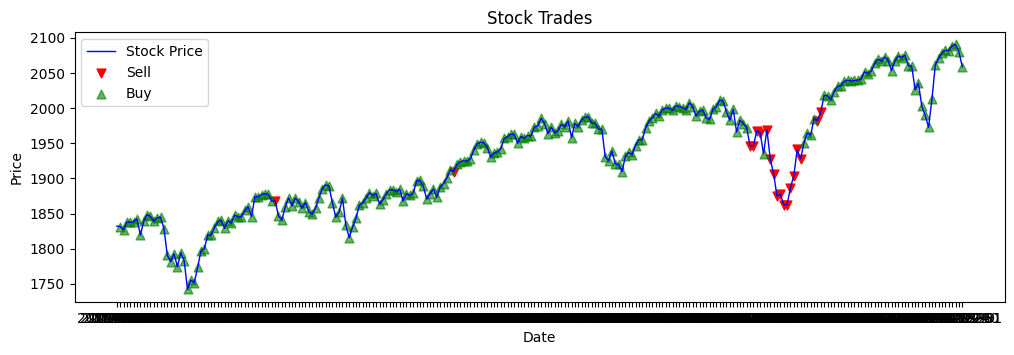

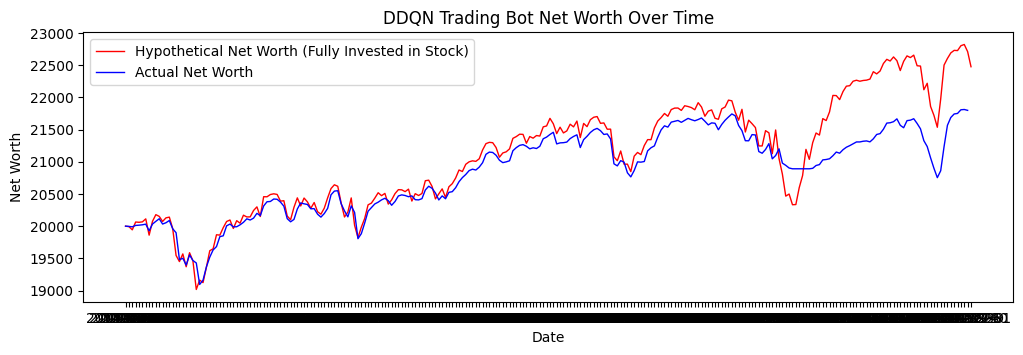

Time: 100 episode: 18/20 score: 20601.681191023574
Time: 200 episode: 18/20 score: 21174.76680028125
Episode 18/20 - NetWorth: 21174.76680028125


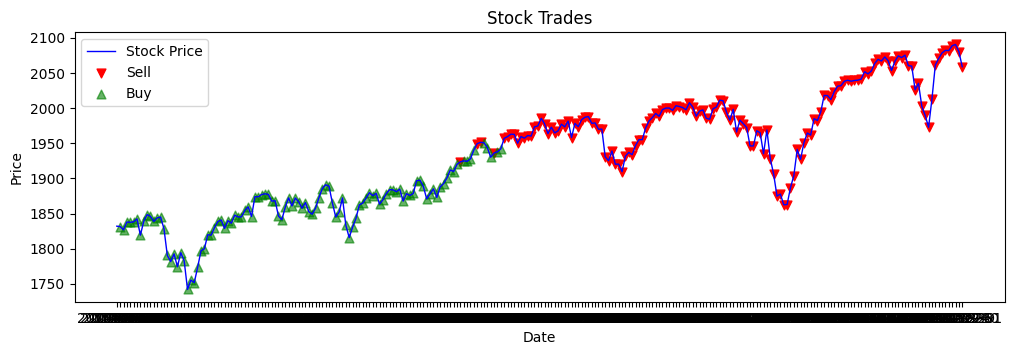

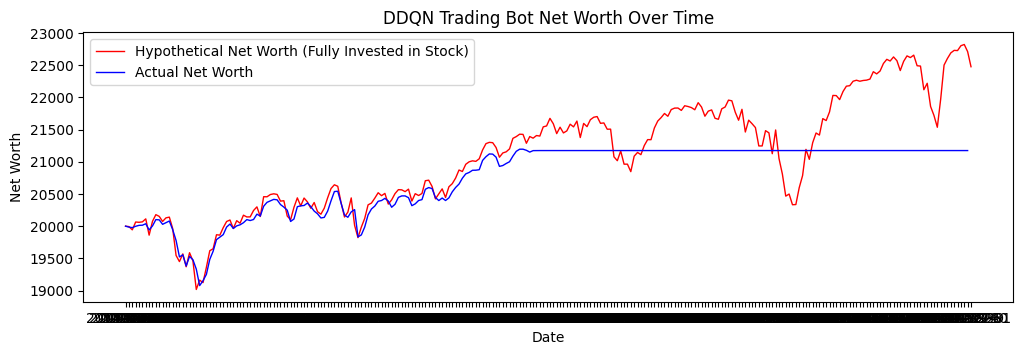

Time: 100 episode: 19/20 score: 20000.0
Time: 200 episode: 19/20 score: 20000.0
Episode 19/20 - NetWorth: 20000.0


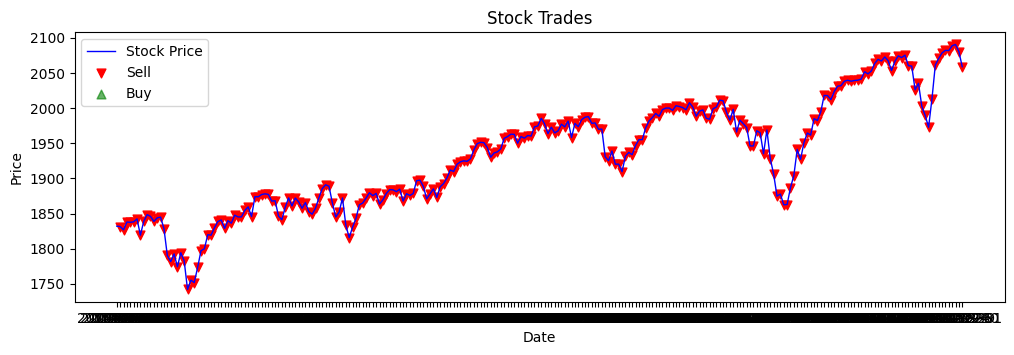

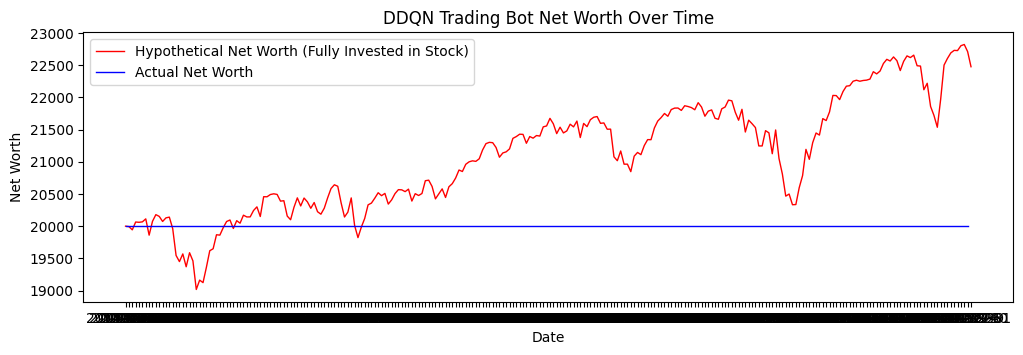

Time: 100 episode: 20/20 score: 20236.199075190456
Time: 200 episode: 20/20 score: 20229.749224976345
Episode 20/20 - NetWorth: 20219.1266996719


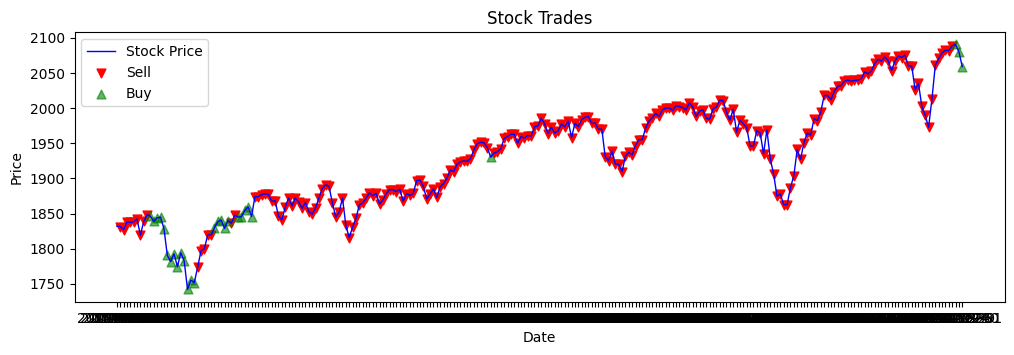

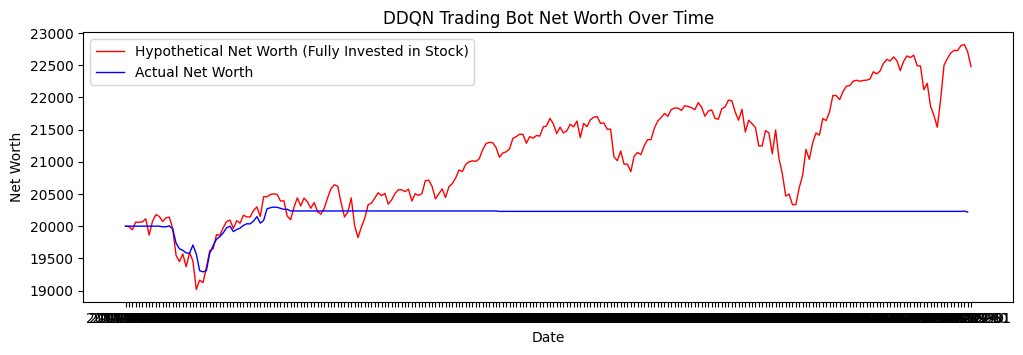

In [7]:
networths = []
for e in range(episodes):
    state = env.reset()
    state = state.flatten()  # Flatten the state to match the input dimensions of the network
    done = False
    trades = []
    networth = []
    for time in range(1,len(env.df)):
        if(time % 100 == 0):
            print(f"Time: {time} episode: {e+1}/{episodes} score: {env.net_worth}")
        action = agent.act(state)
        next_state, reward, done= env.step(action)
        next_state = next_state.flatten()  # Flatten the next state
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        trades.append((env.current_step, action))  # Log the trade action
        if done:
            agent.update_target_model()
            break
        agent.replay()
        networth.append(env.net_worth)
    print(f'Episode {e+1}/{episodes} - NetWorth: {env.net_worth}')
    networths.append(env.net_worth)
    plot_buy_sell(env,trades)
    plot_networth(env,networth)
    if (e + 1) % 10 == 0:
        agent.save(f"model_ddqn_{e+1}")
    agent.save("model_ddqn_temp")

[21812.543545125627, 21290.735828806934, 22473.652156503857, 21644.428959901255, 22452.954549144222, 22478.29684165376, 21027.948007230585, 22538.921934097263, 22443.960805132712, 22992.980782875948, 22565.95346872315, 21564.173534519356, 20002.620627302436, 22111.68051249512, 22429.583592425566, 22475.05441184749, 21799.43252247652, 21174.76680028125, 20000.0, 20219.1266996719]


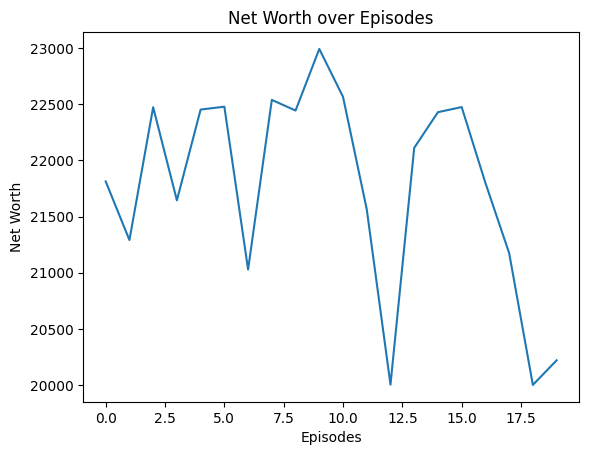

In [8]:
print(networths)
# Plotting the net worth over episodes
plt.plot(range(episodes), networths)
plt.xlabel('Episodes')
plt.ylabel('Net Worth')
plt.title('Net Worth over Episodes')
plt.show()

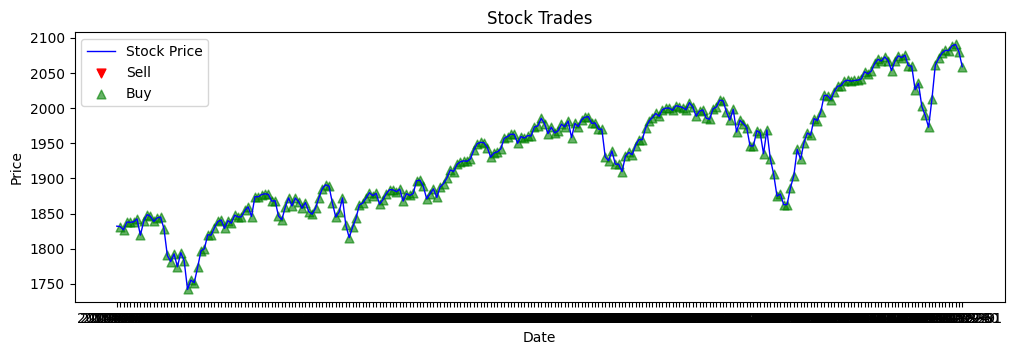

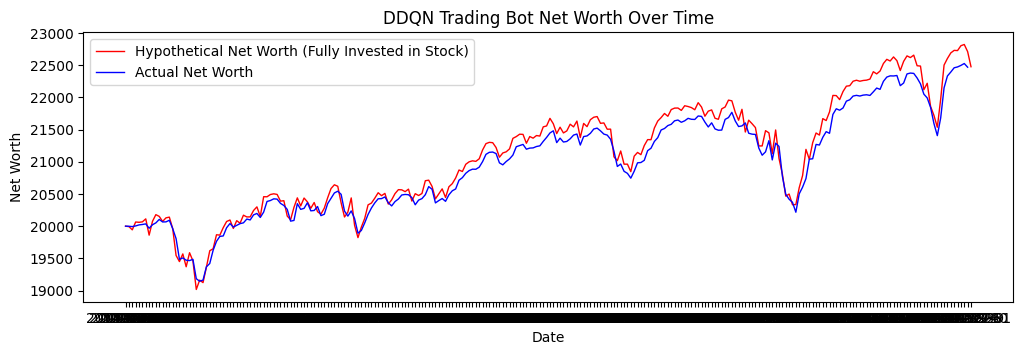

Episode 1/1 - Net Worth: 22469.849316919837
Average net worth over 1 episodes: 22469.849316919837


In [9]:
# Evaluation
def evaluate(env, agent, episodes=1):
    final_net_worths = []
    # total_rewards = 0
    for e in range(episodes):
        trades = []
        state = env.reset()
        state = state.flatten()
        networth = []
        for time in range(1,len(env.df)):
            action = agent.act(state)
            next_state, reward, done= env.step(action)
            trades.append((env.current_step, action))  # Log the trade action
            next_state = next_state.flatten()
            # total_rewards += reward
            state = next_state
            if done:
                break
            networth.append(env.net_worth)
        plot_buy_sell(env,trades)
        plot_networth(env,networth)
        final_net_worths.append(env.net_worth)
        print(f'Episode {e+1}/{episodes} - Net Worth: {env.net_worth}')
        
    print(f"Average net worth over {episodes} episodes: {sum(final_net_worths)/episodes}")
    

# Evaluate the agent
# agent = Agent(state_dim=state_dim)
agent = Agent(state_dim=state_dim,is_eval=True, model_name="model_ddqn_temp.pth")
evaluate(env, agent)
# plt.savefig('saved_visuals/dqn_eval1.jpeg')